Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
...training accuracy 0.083
lamda 0.100000, test accuracy 0.0896
...training accuracy 0.789
lamda 0.010000, test accuracy 0.6735
...training accuracy 0.996
lamda 0.001000, test accuracy 0.8222
Done!


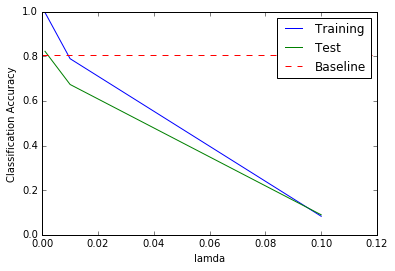

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.examples.tutorials.mnist import input_data

#
# ==================================================================
#

def weight_variable(shape):
    initial = tf.truncated_normal( shape, stddev=0.1 )
    return tf.Variable( initial )

def bias_variable(shape):
    initial = tf.constant( 0.1, shape=shape )
    return tf.Variable(initial)

#
# ==================================================================
#


learning_rate = 0.001
reg = 0.0

# Place holders
y_ = tf.placeholder( tf.float32, shape=[None, 10], name="y_" )
x = tf.placeholder( tf.float32, [None, 784], name="x" )
lamda = tf.placeholder(tf.float32) 



# Defining computation graph for training
def trainWithL1Reg(X):
    global reg
    
    W1 = weight_variable([784, 500])
    b1 = bias_variable([500])
    h1 = tf.nn.relu(tf.matmul( X, W1 ) + b1)
    
    W2 = weight_variable([500, 500])
    b2 = bias_variable([500])
    h2 = tf.nn.relu(tf.matmul( h1, W2 ) + b2)

    W3 = weight_variable([500, 1000])
    b3 = bias_variable([1000])
    h3 = tf.nn.relu(tf.matmul( h2, W3 ) + b3)
    
    #first 6 (next 2 down below)
    reg = tf.reduce_sum(tf.abs(W1))
    reg += tf.reduce_sum(tf.abs(b1))
    reg += tf.reduce_sum(tf.abs(W2))
    reg += tf.reduce_sum(tf.abs(b2))
    reg += tf.reduce_sum(tf.abs(W3))
    reg += tf.reduce_sum(tf.abs(b3))

    out = h3
    return out


# Construct Training Model
out = trainWithL1Reg(x)
W4 = weight_variable([1000, 10])
b4 = bias_variable([10])

# Next 2 : Complete of 8 sums for reg
reg += tf.reduce_sum(tf.abs(W4))
reg += tf.reduce_sum(tf.abs(b4))
    
y_hat = tf.nn.softmax(tf.matmul(out, W4) + b4)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_hat), reduction_indices=[1]))
xent_summary = tf.scalar_summary( 'xent', cross_entropy )

correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
acc_summary = tf.scalar_summary( 'accuracy', accuracy )

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy + lamda*reg)

#
# ==================================================================
#

sess = tf.Session()
sess.run( tf.initialize_all_variables() )

#
# ==================================================================
#

# NOTE: we're using a single, fixed batch of the first 1000 images
mnist = input_data.read_data_sets( "MNIST_data/", one_hot=True )

images = mnist.train.images[ 0:1000, : ]
labels = mnist.train.labels[ 0:1000, : ]

lamdas = [0.1, 0.01, 0.001]
trainingAcc = []
testAcc = []

for l in lamdas:
    sess.run( tf.initialize_all_variables() )
    for i in range( 150 ):
        _, acc = sess.run( [ train_step, accuracy ], feed_dict={ x: images, y_: labels, lamda: l} )
        
    print( "...training accuracy %g" % acc )
    trainingAcc.append(acc)
        
    final_acc = sess.run( accuracy, feed_dict={ x: mnist.test.images, y_: mnist.test.labels, lamda: l } )
    print( "lamda %f, test accuracy %g" % (l, final_acc) )
    testAcc.append(final_acc) 
    
print ("Done!")


baseline = 0.8068
plt.plot(lamdas, trainingAcc, color="blue")
plt.plot(lamdas, testAcc, color="green")
plt.axhline(baseline, color='r', linestyle='--')

plt.legend(['Training', 'Test', 'Baseline'], loc='upper right')
plt.xlabel("lamda")
plt.ylabel("Classification Accuracy")
plt.show()


